<a href="https://colab.research.google.com/github/Praashh/GenAI/blob/main/%F0%9F%A7%91%E2%80%8D%F0%9F%92%BBFraud_Transaction_Detector_(99_98_Accuracy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fraud-transaction-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2793101%2F4821730%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240224%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240224T131110Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D896b381aa8388698a421807429567411ae7061d8a3fecfb7ad961daf9d516fe87793a1145c2318399c415875a9df71fbe682f8ab56eed71910b72f54f26355999ef8ee3e1889e3aefa1587df9a3fa25f0a01b8186c2aeff78d8a8d573b69c143c3a2a3c84ea63f4fa56d2fc7dbe7494365179423cc735b0d23ca620dfe4ae8090c6a991bf815604487be1502df145bfcc68f10efac3eee1b193fc27fd06d3223c3c328ac9494bed445993ecb1d03aeaba888dfe39622391b153edee72db5517b414ff231fd8d7f44477fa9599395fb44e26123f758fe53338cb2d5e771ed779d2d3969795eeef3ad139f880d44da6bca3367d5bf83248a68753e1b9fd71ba29f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 35601528 bytes downloaded
Downloaded and uncompressed: fraud-transaction-detection
Data source import complete.


# <center> 🧑‍💻💰Fraud 🧑‍💻💰 </center>


#### Recognizing fraudulent transactions from legitimate ones has been a challenge for businesses and individuals alike, as scammers continually find new ways to deceive the system. However, with the advent of advanced technologies like machine learning, this task can now be made much easier.

#### Let's see how we can do that

![fraudulent-credit-card-transactions (1).jpg](attachment:350cdf90-cb0d-4850-8e2d-73af8766cd7f.jpg)

# Fraud 🧑‍💻💰: Data Introduction
- **ID**: Represents row number of the transaction in the data.
- **TRANSACTION_ID**: Represents a unique identifier for each transaction.
- **TX_DATETIME**: Represents the date and time of the transaction.
- **CUSTOMER_ID**: Represents the unique identifier of the customer who made the transaction.
- **TERMINAL_ID**: Represents the unique identifier of the terminal where the transaction was made.
- **TX_AMOUNT**: Represents the amount of the transaction.
- **TX_TIME_SECONDS**: Represents the duration of the transaction in seconds.
- **TX_TIME_DAYS**: Represents the duration of the transaction in days.
- **TX_FRAUD**: indicates whether the transaction is fraudulent or not, with 0 representing a legitimate transaction and 1 representing a fraudulent transaction.
- **TX_FRAUD_SCENARIO**: represents the type of fraudulent scenario that was identified, if any. A value of 0 indicates no fraud, and other values indicate different types of fraud scenarios.


# Table of Contents
- [1. Import Libraries](#imports)
- [2. Checking Data 💾](#check)
- [3. Exploratory Data Analysis (EDA) 📊📈](#EDA)
- [4. Data Manipulation 🪄](#Manipulation)
    * Balancing Data
    * Feature Extraction
    * Standardizing Data
- [5. Modeling 🤖](#modeling)
    * Selecting Model
    * Model Optimization
- [6. Evaluation 🧪](#eval)

<a id="imports"></a>
# 1. Import Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score



<a id="check"></a>
# 2. Checking Data 💾

In [3]:
df = pd.read_csv('/kaggle/input/fraud-transaction-detection/Final Transactions.csv')

In [5]:
df.head()

,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,0,0
1,1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,0,0
2,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,1,1
3,3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,0,0
4,4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   TRANSACTION_ID     int64  
 2   TX_DATETIME        object 
 3   CUSTOMER_ID        int64  
 4   TERMINAL_ID        int64  
 5   TX_AMOUNT          float64
 6   TX_TIME_SECONDS    int64  
 7   TX_TIME_DAYS       int64  
 8   TX_FRAUD           int64  
 9   TX_FRAUD_SCENARIO  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 133.8+ MB


In [9]:
df.describe().round()

,Unnamed: 0,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
count,1754155.0,1754155.0,1754155.0,1754155.0,1754155.0,1754155.0,1754155.0,1754155.0,1754155.0
mean,877077.0,877077.0,2504.0,4997.0,540.0,7903234.0,91.0,0.0,0.0
std,506381.0,506381.0,1446.0,2886.0,1180.0,4565172.0,53.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0
25%,438538.0,438538.0,1252.0,2502.0,180.0,3940846.0,45.0,0.0,0.0
50%,877077.0,877077.0,2506.0,4994.0,422.0,7902670.0,91.0,0.0,0.0
75%,1315616.0,1315616.0,3765.0,7495.0,751.0,11865662.0,137.0,0.0,0.0
max,1754154.0,1754154.0,4999.0,9999.0,647838.0,15811197.0,182.0,1.0,3.0


In [10]:
object_cols = ["TX_DATETIME"]

for i in object_cols:
    print("column name : {}".format(i))
    print("Number of unique columns of ", i, ":{}".format(df[i].nunique()))
    print("Values of unique columns of ", i, "is below: \n{}".format(df[i].value_counts()))
    print("------------------------------------------------------------------------")

column name : TX_DATETIME
Number of unique columns of  TX_DATETIME :1635076
Values of unique columns of  TX_DATETIME is below: 
2023-04-03 12:10:19    6
2023-05-01 14:08:48    6
2023-05-12 09:11:39    5
2023-04-16 08:14:22    5
2023-04-26 14:07:42    5
                      ..
2023-03-05 06:37:04    1
2023-03-05 06:36:57    1
2023-03-05 06:36:55    1
2023-03-05 06:36:20    1
2023-07-02 23:59:57    1
Name: TX_DATETIME, Length: 1635076, dtype: int64
------------------------------------------------------------------------


In [12]:
df.isna().sum()

Unnamed: 0           0
TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64

Luckily, there are no null values

<a id="EDA"></a>
# 3. Exploratory Data Analysis (EDA) 📊📈

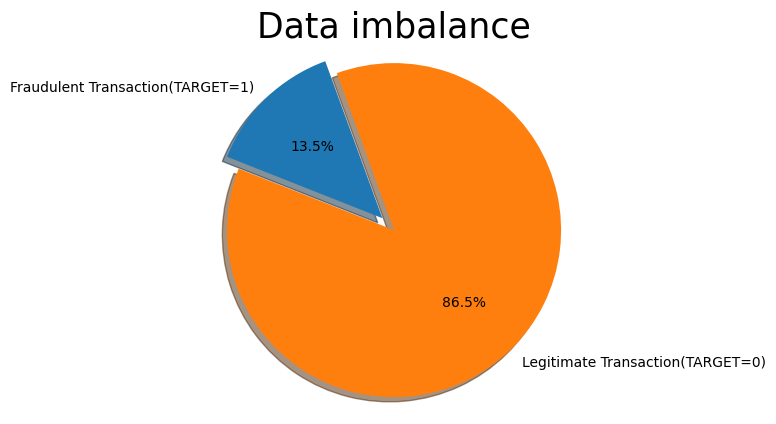

In [13]:
count1 = 0
count0 = 0
for i in df['TX_FRAUD'].values:
    if i == 1:
        count1 += 1
    else:
        count0 += 1

count1 = (count1/len(df['TX_FRAUD']))*100
count0 = (count0/len(df['TX_FRAUD']))*100

x = ['Fraudulent Transaction(TARGET=1)','Legitimate Transaction(TARGET=0)']
y = [count1, count0]


explode = (0.1, 0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(y, explode=explode, labels=x, autopct='%1.1f%%',
        shadow=True, startangle=110)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data imbalance',fontsize=25)
plt.show()

Given that only 13.5% of the data represents fraudulent transactions, the dataset is highly imbalanced. It will be necessary to balance it in order to ensure accurate modeling results.

In [14]:
df = pd.read_csv("/kaggle/input/fraud-transaction-detection/Final Transactions.csv")

df["month"] = pd.DatetimeIndex(df["TX_DATETIME"]).month

grouped = df.groupby(["month", "TX_FRAUD"]).size().reset_index(name="count")

fig = px.bar(grouped, x="month", y="count", color="TX_FRAUD", barmode="group",
             labels={"month": "Month", "count": "Number of Transactions", "TX_FRAUD": "Transaction Type"})

fig.show()

In [15]:
df = pd.read_csv("/kaggle/input/fraud-transaction-detection/Final Transactions.csv")
df = df[(df['TX_FRAUD_SCENARIO'] != 0) & (df['TX_AMOUNT'] != 0)]
grouped = df.groupby("TX_FRAUD_SCENARIO").size().reset_index(name="count")

fig = px.bar(grouped, x="TX_FRAUD_SCENARIO", y="count", color="TX_FRAUD_SCENARIO",
             labels={"TX_FRAUD_SCENARIO": "Fraud Scenario", "count": "Number of Transactions"})

fig.show()

From the bar plot, it is observed that the most frequently occurring fraud scenario is scenario type 1, while the least common scenario is scenario type 3. Next, let's examine the average transaction amount for each type of fraud scenario.

In [ ]:
df = pd.read_csv("/kaggle/input/fraud-transaction-detection/Final Transactions.csv")

df = df[(df['TX_FRAUD_SCENARIO'] != 0) & (df['TX_AMOUNT'] != 0)]

grouped = df.groupby('TX_FRAUD_SCENARIO')['TX_AMOUNT'].mean().reset_index(name='mean_amount')

fig = px.bar(grouped, x='TX_FRAUD_SCENARIO', y='mean_amount', labels={'TX_FRAUD_SCENARIO':'Fraud Scenario','mean_amount':'Average Transaction Amount'})

fig.show()

As seen from the bar plot, scenario type 3 has the highest average transaction amount of 12.7k, yet it is the least common scenario type. Meanwhile, scenario type 2, despite being the second most common scenario type, has the lowest average transaction amount of 515. The most common scenario type, type 1, has an average transaction amount of 1281.

In [ ]:

df = pd.read_csv("/kaggle/input/fraud-transaction-detection/Final Transactions.csv")

df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

df['date'] = df['TX_DATETIME'].dt.date

grouped = df[df['TX_FRAUD'] == 1].groupby('date').size().reset_index(name='count')

fig = px.line(grouped, x='date', y='count', labels={'date':'Date','count':'Number of Fraud Transactions'})

fig.show()

The line plot shows that on January 2nd, 2023, there were 1182 fraudulent transactions, which is the lowest number of fraudulent transactions in a single day. On the other hand, on February 2nd, 2023, the highest number of fraudulent transactions, 1414, were recorded.

<a id="Manipulation"></a>
# 4. Data Manipulation 🪄

- <h2> Balancing Data </h2>

In [ ]:
df = pd.read_csv('/kaggle/input/fraud-transaction-detection/Final Transactions.csv')

df = df.drop(df.index[0])

fraud = df[df['TX_FRAUD'] == 1]

non_fraud = df[df['TX_FRAUD'] == 0]

n_non_fraud = len(non_fraud)

fraud_upsampled = fraud.sample(n_non_fraud, replace=True)

df_upsampled = pd.concat([fraud_upsampled, non_fraud])

df = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

df.to_csv('cleaned_transactions.csv', index=False)

The data has been balanced through the process of upsampling. To visualize the balance of the data, Let's create a pie chart.

In [ ]:
df = df_upsampled
count1 = 0
count0 = 0
for i in df['TX_FRAUD'].values:
    if i == 1:
        count1 += 1
    else:
        count0 += 1

count1 = (count1/len(df['TX_FRAUD']))*100
count0 = (count0/len(df['TX_FRAUD']))*100

x = ['Fraudulent Transaction(TARGET=1)','Legitimate Transaction(TARGET=0)']
y = [count1, count0]


explode = (0.1, 0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(y, explode=explode, labels=x, autopct='%1.1f%%',
        shadow=True, startangle=110)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data imbalance',fontsize=25)
plt.show()

as we can see data is now balanced

- <h2> Feature Extraction </h2>


In [ ]:

df = pd.read_csv('/kaggle/working/cleaned_transactions.csv')

df_features = df.drop(['TRANSACTION_ID', 'TX_FRAUD','TX_DATETIME','Unnamed: 0','CUSTOMER_ID','TERMINAL_ID','TX_FRAUD_SCENARIO'], axis=1)

print(df_features.head())

- <h2>Standardizing Data</h2>

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

standardized_features = scaler.fit_transform(df_features)

<a id="modeling"></a>
# 5. Modeling 🤖

- <h2> Selecting Model </h2>

In [ ]:
df = pd.read_csv("/kaggle/working/cleaned_transactions.csv")
X = standardized_features
y = df["TX_FRAUD"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [ ]:

models = {"Logistic Regression": LogisticRegression(),
          "K-Nearest Neighbors": KNeighborsClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "Random Forest": RandomForestClassifier(),
          "Gradient Boosting": GradientBoostingClassifier()}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} accuracy: {acc:.3f}")

We are going to use Decision Tree Classifier and Random Forest. My plan is to use GridSearchCV and see if we can dump up accuracy on Decision Tree Classifier.

- <h2> Model 1) Decision Tree Classifier </h2>

* <h3> Model Optimization</h3>

In [ ]:
dt_clf = DecisionTreeClassifier()

param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_test, y_test)

print("Best hyperparameters: ", grid_search.best_params_)

* <h3>Optimised Model </h3>

In [ ]:
model = DecisionTreeClassifier(max_depth= None, min_samples_leaf=1,min_samples_split=2)
model.fit(X_train, y_train)

y_pred_DTC = model.predict(X_test)

acc = accuracy_score(y_test, y_pred_DTC)
cm_DTC = confusion_matrix(y_test, y_pred_DTC)
print("Decision Tree Classifier:")
print("Accuracy:", acc)
print("Confusion Matrix:\n", cm_DTC)

- <h2>Model 2) RandomForestClassifier</h2>

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred_RFC = model.predict(X_test)

acc = accuracy_score(y_test, y_pred_RFC)
cm_RFC = confusion_matrix(y_test, y_pred_RFC)
print("Random Forest Classifier:")
print("Accuracy:", acc)
print("Confusion Matrix:\n", cm_RFC)

<a id = "eval"></a>
# 6. Evaluation 🧪

In [ ]:
cm_sns_DTC = sns.heatmap(cm_DTC,annot=True,fmt='.1f')
cm_sns_DTC.set_title('Confusion Matrix: Decision Tree Classifier')

In [ ]:
cm_sns_RFC = sns.heatmap(cm_RFC,annot=True,fmt='.1f')
cm_sns_RFC.set_title('Confusion Matrix: Random Forest Classifier')

In [ ]:
precision_DTC = precision_score(y_test, y_pred_DTC)
recall_DTC = recall_score(y_test, y_pred_DTC)
f1_DTC = f1_score(y_test, y_pred_DTC)
print("Decision Tree Classifier:")
print("Precision: ", precision_DTC)
print("Recall: ", recall_DTC)
print("F1-Score: ", f1_DTC)

In [ ]:
precision_RFC = precision_score(y_test, y_pred_RFC)
recall_RFC = recall_score(y_test, y_pred_RFC)
f1_RFC = f1_score(y_test, y_pred_RFC)
print("Random Forest Classifier")
print("Precision: ", precision_RFC)
print("Recall: ", recall_RFC)
print("F1-Score: ", f1_RFC)

In [ ]:
classifiers = ['Decision Tree Classifier', 'Random Forest Classifier']
metrics = ['Precision', 'Recall', 'F1-Score']

df = pd.DataFrame({'Classifier': [classifiers[0]]*3 + [classifiers[1]]*3,
                   'Metrics': metrics*2,
                   'Score': [precision_DTC, recall_DTC, f1_DTC, precision_RFC, recall_RFC, f1_RFC]})

fig = px.bar(df, x='Classifier', y='Score', color='Metrics', barmode='group',
             height=400, width=600, title="Classifier Performance Metrics")

fig.update_layout(xaxis=dict(categoryorder='category ascending'))
fig.update_traces(customdata=df['Score'],texttemplate='%{customdata}', textposition='auto', textfont=dict(size=8))
fig.update_traces(text=df['Score'], texttemplate='%{text}', textposition='outside', textfont=dict(size=8))
fig.update_traces(hovertemplate='%{x}<br>Score: %{y:.4f}<extra></extra>')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_traces(text=df['Score'].round(2).astype(str), texttemplate='%{text:.4f}', textposition='outside', textfont=dict(size=8))
fig.show()

In [ ]:
average_precision = average_precision_score(y_test, y_pred_DTC)

print("Average precision-recall score: {:.2f}".format(average_precision))

In [ ]:
average_precision_RFC = average_precision_score(y_test, y_pred_RFC)

print("Average precision-recall score: {:.2f}".format(average_precision))

![CatStickerLineStickerGIF.gif](attachment:5219da64-a70c-40cb-84ef-ea62af7db7a3.gif)

<center><p style="color:red;">💬 Thanks for reading till here!! If you liked the notebook then please do Upvote👍, and do give some remarks/advice if you think anything needs to be added/modified.</p></center>